Variational Autoencoder

Linear operations apply affine transform $y = x A^T + b$. Documentation for `torch.nn.Linear()`:  
<https://pytorch.org/docs/stable/generated/torch.nn.Linear.html>

Based on code from:  
<https://avandekleut.github.io/vae/>

In [1]:
import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200

def display_imagearray(ax, img):
    ax.imshow(img)
    ax.set_xticks([])
    ax.set_yticks([])

In [2]:
class VariationalEncoder(nn.Module):
    def __init__(self, latent_dims):
        super().__init__()
        self.linear1 = nn.Linear(784, 512)
        self.linear2 = nn.Linear(512, latent_dims)
        self.linear3 = nn.Linear(512, latent_dims)

        self.N = torch.distributions.Normal(0, 1)
        self.N.loc = self.N.loc.cuda() # hack to get sampling on the GPU
        self.N.scale = self.N.scale.cuda()
        self.kl = 0

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        mu =  self.linear2(x)
        sigma = torch.exp(self.linear3(x))
        z = mu + sigma*self.N.sample(mu.shape)
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
        return z

class Decoder(nn.Module):
    def __init__(self, latent_dims):
        super().__init__()
        self.linear1 = nn.Linear(latent_dims, 512)
        self.linear2 = nn.Linear(512, 784)

    def forward(self, z):
        z = F.relu(self.linear1(z))
        z = torch.sigmoid(self.linear2(z))
        return z.reshape((-1, 1, 28, 28))
    
class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims):
        super().__init__()
        self.encoder = VariationalEncoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
latent_dims = 2

data = torch.utils.data.DataLoader(
        torchvision.datasets.MNIST('../data',
               transform=torchvision.transforms.ToTensor(),
               download=True),
        batch_size=128,
        shuffle=True)

Train a new model instance or load a pre-trained instance

Documentation to save and load models:  
<https://pytorch.org/tutorials/beginner/saving_loading_models.html>

In [5]:
def train(autoencoder, data, epochs=20):
    opt = torch.optim.Adam(autoencoder.parameters())
    for epoch in range(epochs):
        prefix = f"Training Epoch {epoch}: "
        for x, y in tqdm(data, desc=prefix, 
                dynamic_ncols=True, leave=True, position=0):
            x = x.to(device) # GPU
            opt.zero_grad()
            x_hat = autoencoder(x)
            loss = ((x - x_hat)**2).sum() + autoencoder.encoder.kl
            loss.backward()
            opt.step()
    return autoencoder

vae = VariationalAutoencoder(latent_dims).to(device) # GPU
should_create_new_instance = False
if should_create_new_instance:
    vae = train(vae, data)
    torch.save(vae.state_dict(), './models/vae-2.pth')
else:
    vae.load_state_dict(torch.load('./models/vae-2.pth'))

Inspect the reconstructions of the variational autoencoder

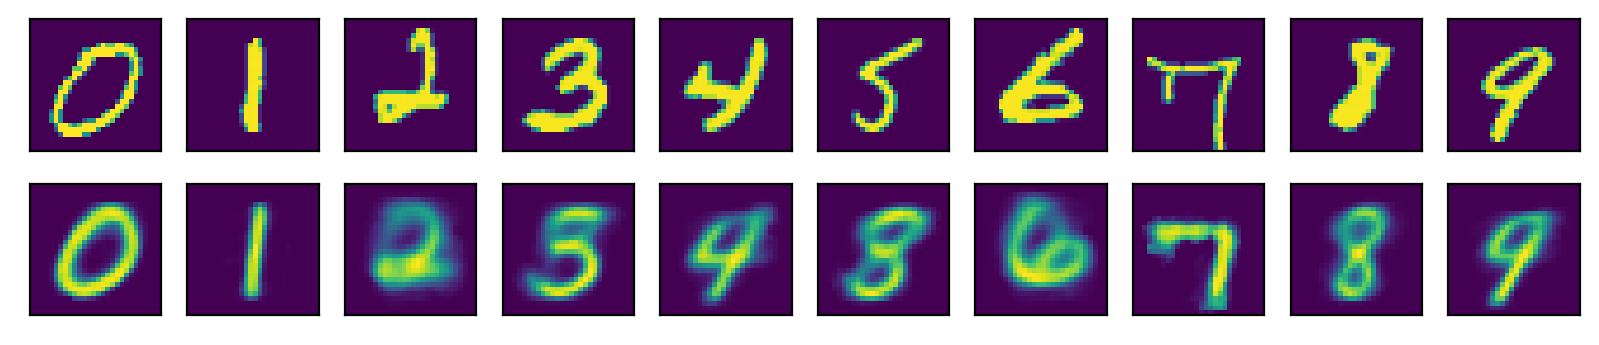

In [6]:
fig, axes = plt.subplots(2, 10, figsize=(10,2))
# axes = axes.ravel()

for n in range(10):
    # x has shape (batch size, 1, 28, 28)
    # y has shape (batch size,)
    x, y = data.__iter__().next() # hack to grab a batch
    x = x[y == n][0] # get sample corresponding to number n

    img = x.numpy().reshape(28, 28)
    display_imagearray(axes[0, n], img)

    # x has shape (1, 28, 28)
    x = x.to(device)
    # z has shape (1, 2)
    z = vae.encoder(x)
    # x_hat has shape (1, 1, 28, 28)
    x_hat = vae.decoder(z)

    img = x_hat.cpu().detach().numpy().reshape(28, 28)
    display_imagearray(axes[1, n], img)

Inspect the operations made in the variational autoencoder

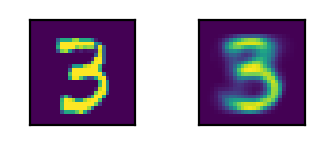

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(2,0.7))
axes = axes.ravel()

# x has shape (batch size, 1, 28, 28)
# y has shape (batch size,)
x, y = data.__iter__().next() # hack to grab a batch
x = x[y == 3][0] # get sample corresponding to number n

img = x.numpy().reshape(28, 28)
display_imagearray(axes[0], img)

# x has shape (1, 28, 28)
x = x.to(device)
# x has shape (1, 784)
x = torch.flatten(x, start_dim=1)
# x has shape (1, 512)
x = F.relu(vae.encoder.linear1(x))

# mu, sigma, eps has shape (1, 2)
mu =  vae.encoder.linear2(x)
sigma = torch.exp(vae.encoder.linear3(x))
eps = vae.encoder.N.sample(mu.shape)
# z has shape (1, 2)
z = mu + sigma*eps
# z has shape (1, 512)
z = F.relu(vae.decoder.linear1(z))
# z has shape (1, 784)
z = torch.sigmoid(vae.decoder.linear2(z))
# x_hat has shape (1, 1, 28, 28)
x_hat = z.reshape((-1, 1, 28, 28))

img = x_hat.cpu().detach().numpy().reshape(28, 28)
display_imagearray(axes[1], img)

In [8]:
class VariationalEncoder(nn.Module):
    def __init__(self, latent_dims):
        super().__init__()
        self.linear1 = nn.Linear(784, 512)
        self.linear2 = nn.Linear(512, latent_dims)
        self.linear3 = nn.Linear(512, latent_dims)

        self.N = torch.distributions.Normal(0, 1)
        self.N.loc = self.N.loc.cuda() # hack to get sampling on the GPU
        self.N.scale = self.N.scale.cuda()
        self.kl = 0

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        mu =  self.linear2(x)
        sigma = torch.exp(self.linear3(x))
        z = mu + sigma*self.N.sample(mu.shape)
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
        return z

class Decoder(nn.Module):
    def __init__(self, latent_dims):
        super().__init__()
        self.linear1 = nn.Linear(latent_dims, 512)
        self.linear2 = nn.Linear(512, 784)

    def forward(self, z):
        z = F.relu(self.linear1(z))
        z = torch.sigmoid(self.linear2(z))
        return z.reshape((-1, 1, 28, 28))
    
class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims):
        super().__init__()
        self.encoder = VariationalEncoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

In [17]:
def plot_latent(autoencoder, data, num_batches=100):
    for i, (x, y) in enumerate(data):
        z = autoencoder.encoder(x.to(device))
        z = z.to('cpu').detach().numpy()
        plt.scatter(z[:, 0], z[:, 1], c=y, cmap='tab10')
        if i > num_batches:
            plt.colorbar()
            break

def plot_reconstructed(autoencoder, r0=(-5, 10), r1=(-10, 5), n=12):
    w = 28
    img = np.zeros((n*w, n*w))
    for i, y in enumerate(np.linspace(*r1, n)):
        for j, x in enumerate(np.linspace(*r0, n)):
            z = torch.Tensor([[x, y]]).to(device)
            x_hat = autoencoder.decoder(z)
            x_hat = x_hat.reshape(28, 28).to('cpu').detach().numpy()
            img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat
    plt.imshow(img, extent=[*r0, *r1])
    plt.xlabel('latent variable 1')
    plt.ylabel('latent variable 2')

def interpolate(autoencoder, x_1, x_2, n=12):
    z_1 = autoencoder.encoder(x_1)
    z_2 = autoencoder.encoder(x_2)
    z = torch.stack([z_1 + (z_2 - z_1)*t for t in np.linspace(0, 1, n)])
    interpolate_list = autoencoder.decoder(z)
    interpolate_list = interpolate_list.to('cpu').detach().numpy()

    w = 28
    img = np.zeros((w, n*w))
    for i, x_hat in enumerate(interpolate_list):
        img[:, i*w:(i+1)*w] = x_hat.reshape(28, 28)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])

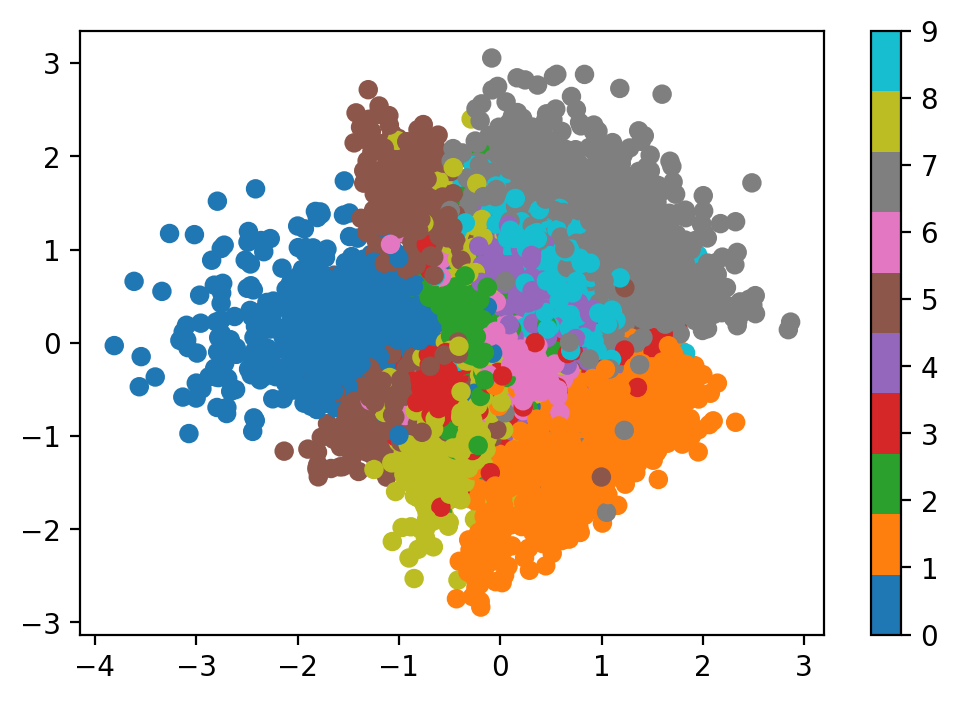

In [18]:
plot_latent(vae, data)

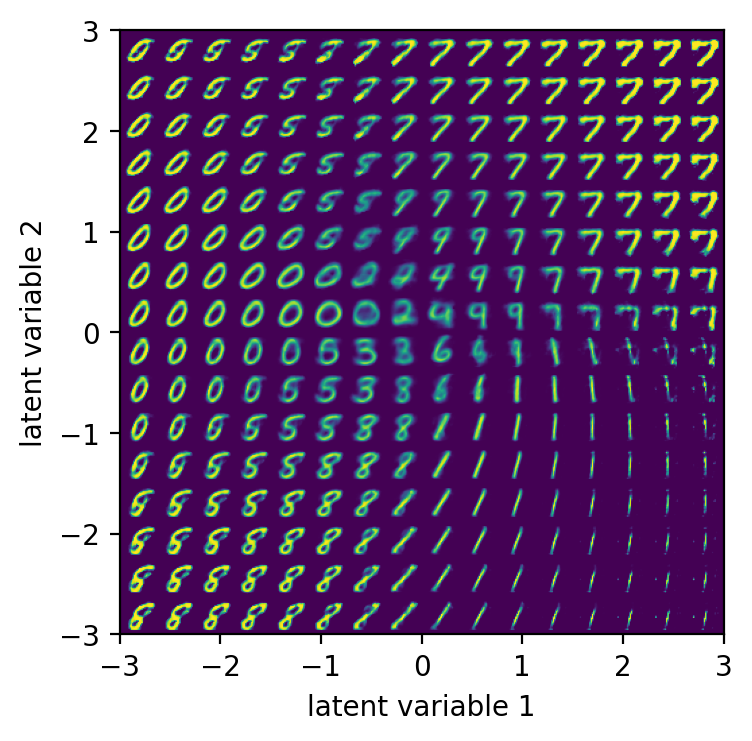

In [19]:
plot_reconstructed(vae, r0=(-3, 3), r1=(-3, 3), n=16)

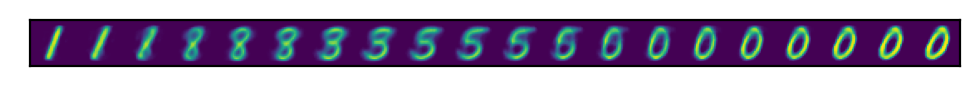

In [9]:
x, y = data.__iter__().next() # hack to grab a batch
x_1 = x[y == 1][1].to(device) # find a 1
x_2 = x[y == 0][1].to(device) # find a 0
interpolate(vae, x_1, x_2, n=20)